In [2]:
import numpy as np
import time
import pandas as pd 
import matplotlib.pyplot as plt
import math 
import random
import scipy.io as spio
import collections
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

In [39]:
train = pd.read_csv("cbb.csv")
eps = 0.01175 # 0.01125 or 0.0105
minpts = 7

In [4]:
train.drop(["TEAM", "CONF", "POSTSEASON", "SEED"], axis = 1, inplace = True)

In [5]:
def normalize(data):
  normData = data.copy()
  for i in range(data.shape[1]):
    normData.iloc[:,i] /= np.linalg.norm(data.iloc[:,i])
  return normData

In [6]:
def split_dataset(data, p=0.9): 
  embaralhado = data.iloc[np.random.permutation(len(data))]
  d1 = embaralhado.iloc[0:int(embaralhado.shape[0]*p),:]
  d2 = embaralhado.iloc[int(embaralhado.shape[0]*p):,:]
  return d1,d2

In [7]:
def module(i, j):
    return np.linalg.norm(i - j)
def distance_two_points (i,j):
    return math.sqrt(abs(sum(i**2-j**2)))
def distance(V):
    return math.sqrt(sum(v**2 for v in V))

In [8]:
def ExpandClusters(data, points_labels, id_seed, neighbor_points, C, epsilon, min_pts, core_points):
    # coloca o id do cluster no ponto atual
    points_labels[id_seed] = C
   
    i = 0
    while i < len(neighbor_points):        
        next_position = neighbor_points[i]
        if points_labels[next_position] == 0:
           points_labels[next_position] = C
        
        # se o ponto vizinho ainda nao tinha cluster agora ele tem
        elif points_labels[next_position] == -1:
            points_labels[next_position] = C
            
            pn_neighbor = [i for i in range(len(data)) if np.linalg.norm(data[i,:]-data[next_position,:]) 
                           <= epsilon]
            #se o ponto tem filhos, adiciona eles na fila 
            if len(pn_neighbor) > min_pts:
                neighbor_points = neighbor_points + pn_neighbor
                core_points.append(next_position)
        i += 1
    return core_points

In [9]:
def DBSCAN(data, epsilon, minP):
  C = 0
  point_label = np.full(len(data), -1, dtype=int) 
  core_points = []
  for p in range(len(data)):
    if point_label[p] != -1: continue
    current_point = data[p]
    # armazena os pontos vizinhos ao ponto p.
    neighbor_points = [i for i in range(len(data)) if np.linalg.norm(data[i,:]-current_point) <= epsilon]
  
    # o ponto nao tem vizinhos o suficiente
    if len(neighbor_points) <= minP:
      point_label[p] = 0
    # tem vizinhos o suficiente para criar um novo clusters
    else:
      C += 1
      core_points.append(p)
      core_points = ExpandClusters(data, point_label, p, neighbor_points, C, epsilon, minP, core_points)

  return point_label, core_points, C

In [10]:
#Function to plot final result
def plotRes(train, point_labels, main_title):
  dicColors = {0:'black', 1:'yellow', 2:'purple', 3:'red', 4:'blue', 5:'green', 
              6:'orange', 7:'violet', 8:'brown', 9:'cyan', 10:'magenta'}    
  label_color = [dicColors[c%11] for c in point_labels] 
  x_label = 'NUMBER OF GAMES PLAYED'
  y_label = 'NUMBER OF GAMES WON'
  z_label = 'YEAR'
  title = main_title 

  # creating figure
  fig = plt.figure(figsize=(15,15))
  ax = plt.axes(projection ="3d")
  
  # creating plot
  ax.scatter3D(train.iloc[:,0], train.iloc[:,1], train.iloc[:,19],c=label_color,alpha=0.6)
  
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_zlabel(z_label)

  plt.suptitle(title, fontsize=20)  
  plt.savefig(title + '.png')
  plt.show()

In [11]:
def callPlot(train_data,pointlabel, main_title):
  plotRes(train_data, pointlabel, main_title) 
  plt.show()
  counter=collections.Counter(pointlabel)
  print(counter)
  outliers  = np.count_nonzero(pointlabel == 0)
  print('number of outliers found: '+str(outliers) +'\n')

In [12]:
# checar depois: https://gist.github.com/AlexandreAbraham/5544803
def find_clusters_and_centroids(norm_dataset, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in range(len(norm_dataset)):    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

# usado apenas pela funcao predict.
def find_clusters_and_centroids_core (norm_dataset, core_points, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in core_points:    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

In [13]:
def elbow (norm_data, clusters, centroids):
    centroids = np.asarray(centroids)
    elbow = 0
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not math.isnan(clusters[i][j]) and not math.isnan(centroids[i][0][0]):    
                # elbow: soma (ao quadrado) das distancias de p a todos pts. c pertencentes ao cluster C
                elbow += (math.dist(norm_data[np.asarray(clusters[i][j]).astype(int)], centroids[i][0]))**2
    return elbow

In [14]:
def silhouette (norm_data, clusters, centroids):
    sil = 0
    for i in range(len(clusters)):
        a = 0
        inf = 10000000
        for p in range(len(clusters[i])):
            if not math.isnan(centroids[i][0][0]):
                
                # a: encontra a média entre a e as distancias em relacao aos outros pts. do cluster.
                a = math.dist(norm_data[np.asarray(clusters[i][p]).astype(int)], centroids[i][0])
                b = inf

                # b: encontra a distancia do ponto ao ponto mais próximo do cluster mais próximo.
                for j in range(len(centroids)): 
                    if i != j and not math.isnan(centroids[j][0][0]):
                        # notice that len centroids equals len clusters
                        b = min(b, math.dist(norm_data[np.asarray(clusters[i][p]).astype(int)], 
                                          centroids[j][0]))
                
                # just to guarantee that sil won't tend to 1 if it has no or only one cluster
                if b == inf: 
                    b = a
                sil += (b - a)/(max(a, b)+0.000000001)
    sil /= len(norm_data)
    return sil;

In [15]:
# input *core* clusters 
def predict(pred_dataset, norm_orig_dataset, clusters, orig_point_labels, eps):
    norm_pred_dataset = pred_dataset # normalize(pred_dataset).to_numpy()
    pred_point_labels = np.zeros(len(norm_pred_dataset),dtype=int)
    for i in range(len(norm_pred_dataset)):
        for j in range(len(clusters)):
            for cp in clusters[j]:
                cp = round(cp)
                dist = np.linalg.norm(norm_pred_dataset.iloc[i,:] - norm_orig_dataset.iloc[cp,:]) 
                
                if (dist  <= eps):
                    pred_point_labels[i] = orig_point_labels[cp] 
                    break  
    return pred_point_labels

In [24]:
# dataset has to be a DataFrame
def validate(dataset, 
             # epsilon=[0.01050, 0.01075, 0.011, 0.01125, 0.01150, 0.01175, 0.01200, 0.01225],
             epsilon=[0.009, 0.01, 0.01050, 0.01125, 0.01150, 0.01175], 
             min_points=[3, 7, 14]):
  for minpts in min_points:
      somaDasSilhuetas = []
      somaDosQuadrados = []
      conjuntoEpsilons = []
      
      for eps in epsilon:
        conjuntoEpsilons.append(eps)
        norm_dataset = dataset.to_numpy()
        point_labels, core_points, n_clusters = DBSCAN(norm_dataset,eps,minpts)
        clusters, centroids = find_clusters_and_centroids(
                              norm_dataset, point_labels, n_clusters
        )
        elbow_val = elbow(norm_dataset, clusters, centroids)
        somaDosQuadrados.append(elbow_val)
        sil = silhouette(norm_dataset, clusters, centroids)
        somaDasSilhuetas.append(sil)
        print("epsilon: {}, elbow: {}, sil: {}".format(eps, elbow_val, sil))
        # callPlot(dataset, point_labels, "DBSCAN clusters for eps: "+ str(eps))

      print("Epsilons:")
      print(conjuntoEpsilons)
      print("Cotovelo:")
      print(somaDosQuadrados)
      print("Coef. Silhueta:")
      print(somaDasSilhuetas)

      fig, ax1 = plt.subplots()
      ax2 = ax1.twinx()

      color1 = 'tab:blue'
      color2 = 'tab:red'

      ax1.plot(epsilon, somaDosQuadrados, 'x-', color=color1)
      ax2.plot(epsilon, somaDasSilhuetas, 'x-', color=color2)

      ax1.set_xlabel('epsilon')
      ax1.set_ylabel('SSE', color = color1)
      ax2.set_ylabel('silhouette coef.', color = color2) 
      plt.savefig('cbb.csv - evaluation of best epilons. min pts.:' + str(minpts) +'.png')
      plt.show()

In [17]:
# Split and initialize training & validation & test data separately
norm_train = normalize(train) # .to_numpy()
norm_train_np = norm_train.to_numpy()
training, test = split_dataset(norm_train)
training, validation = split_dataset(training)
norm_training_np =  training.to_numpy()
norm_validation_np = validation.to_numpy()

In [20]:
point_labels, core_points, n_clusters = DBSCAN(norm_train_np,eps,minpts)

In [40]:
point_labels_train, core_points_train, n_clusters_train = DBSCAN(norm_training_np, eps, minpts)

In [59]:
clusters_train, centroids_train = find_clusters_and_centroids_core (
    training, core_points_train, point_labels_train, n_clusters_train
)

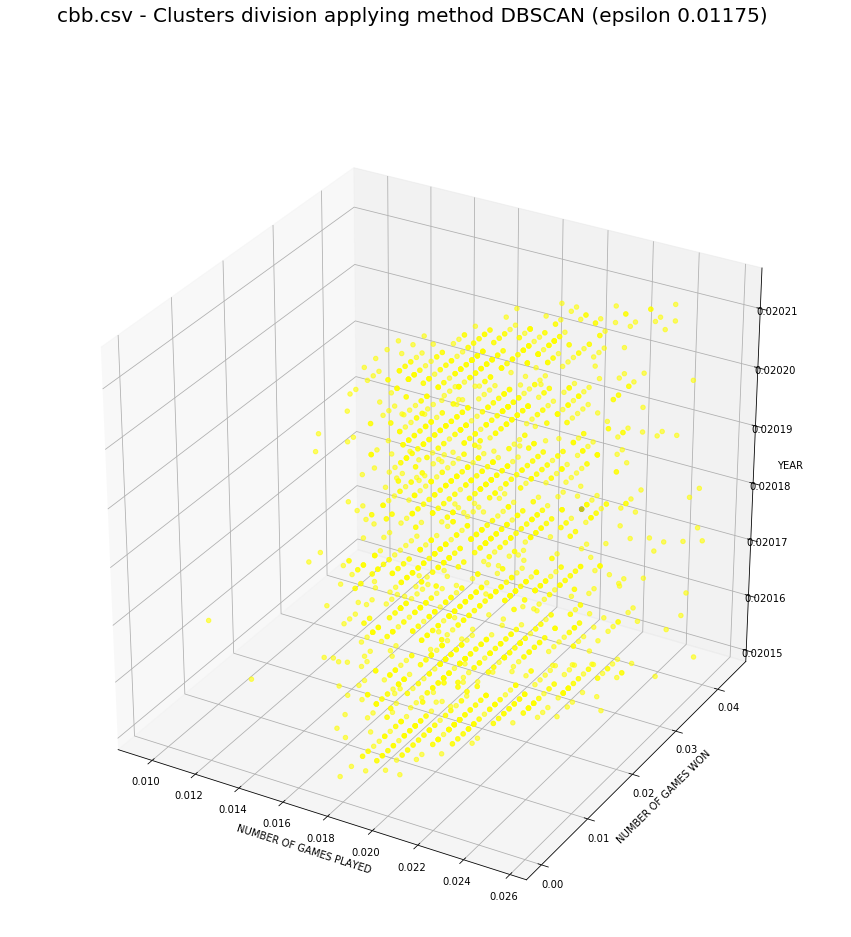

Counter({1: 1987, 0: 1})
number of outliers found: 1



In [41]:
callPlot(training, point_labels_train,
     'cbb.csv - Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ')')

In [61]:
point_labels_valid = predict(validation, training, clusters_train, point_labels_train, eps)

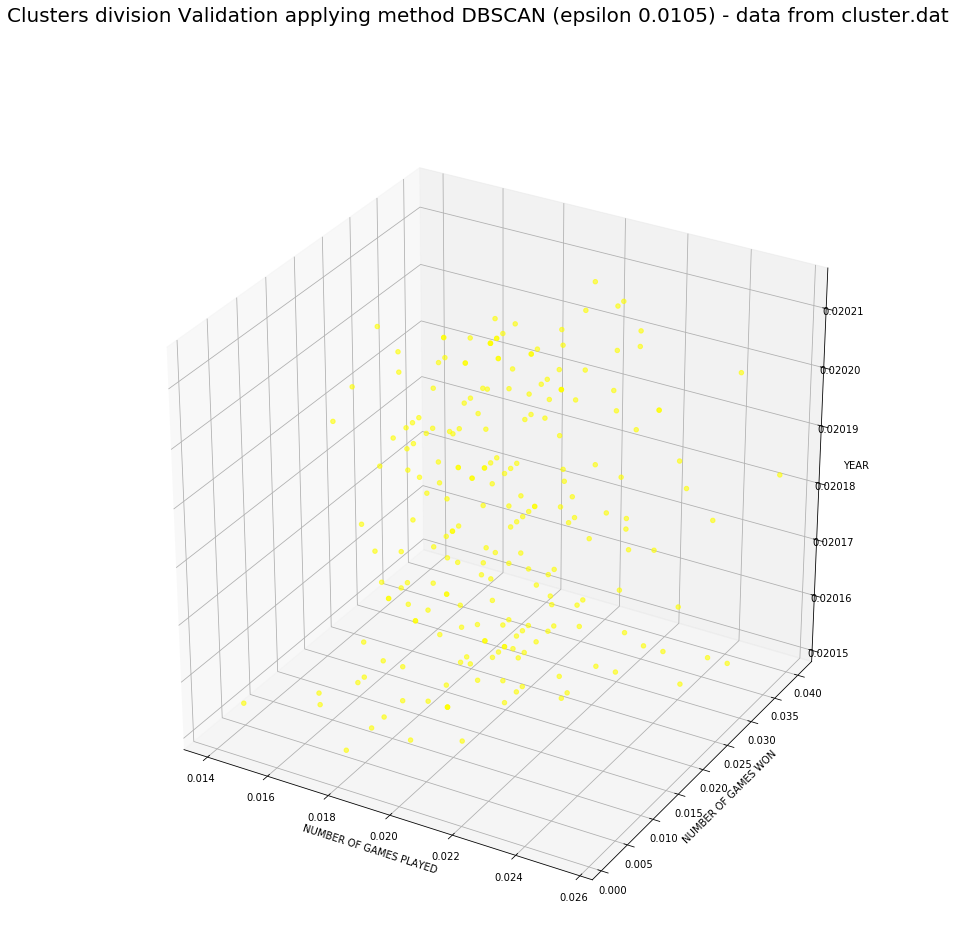

Counter({1: 221})
number of outliers found: 0



In [62]:
callPlot(validation, point_labels_valid,
     'Clusters division Validation applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

epsilon: 0.009, elbow: 0.768851204929824, sil: 0.085129203603698
epsilon: 0.01, elbow: 0.7693784392324576, sil: 0.19790394904762293
epsilon: 0.0105, elbow: 0.7692591142382377, sil: 0.2673265115156106
epsilon: 0.01125, elbow: 0.7693589340834945, sil: 0.3247958013735899
epsilon: 0.0115, elbow: 0.7699109127560164, sil: 0.3488536371997989
epsilon: 0.01175, elbow: 0.7702583260200891, sil: 0.0
Epsilons:
[0.009, 0.01, 0.0105, 0.01125, 0.0115, 0.01175]
Cotovelo:
[0.768851204929824, 0.7693784392324576, 0.7692591142382377, 0.7693589340834945, 0.7699109127560164, 0.7702583260200891]
Coef. Silhueta:
[0.085129203603698, 0.19790394904762293, 0.2673265115156106, 0.3247958013735899, 0.3488536371997989, 0.0]


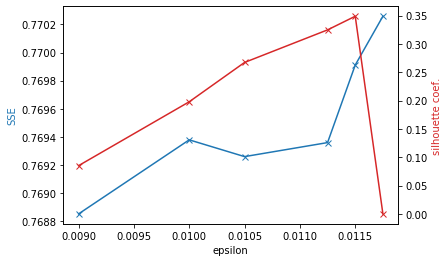

epsilon: 0.009, elbow: 0.7691282400809656, sil: 0.08351289567651002
epsilon: 0.01, elbow: 0.7692589233153903, sil: 0.18844091266051008
epsilon: 0.0105, elbow: 0.7692591142382377, sil: 0.2673265115156106
epsilon: 0.01125, elbow: 0.7693589340834945, sil: 0.3247958013735899
epsilon: 0.0115, elbow: 0.7693589340834945, sil: 0.3247958013735899
epsilon: 0.01175, elbow: 0.7687470009288869, sil: 0.5043302268439822
Epsilons:
[0.009, 0.01, 0.0105, 0.01125, 0.0115, 0.01175]
Cotovelo:
[0.7691282400809656, 0.7692589233153903, 0.7692591142382377, 0.7693589340834945, 0.7693589340834945, 0.7687470009288869]
Coef. Silhueta:
[0.08351289567651002, 0.18844091266051008, 0.2673265115156106, 0.3247958013735899, 0.3247958013735899, 0.5043302268439822]


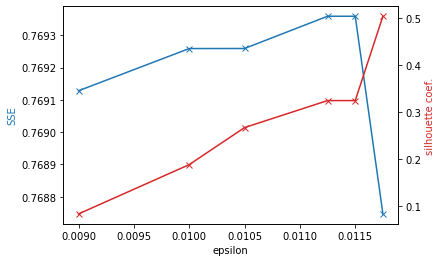

epsilon: 0.009, elbow: 0.7689453506997559, sil: 0.08700381247875383
epsilon: 0.01, elbow: 0.769175685463807, sil: 0.18577158704855867
epsilon: 0.0105, elbow: 0.7694281433128781, sil: 0.23558287048439835
epsilon: 0.01125, elbow: 0.7693589340834945, sil: 0.3247958013735899
epsilon: 0.0115, elbow: 0.7693589340834945, sil: 0.3247958013735899
epsilon: 0.01175, elbow: 0.7687470009288869, sil: 0.5043302268439822
Epsilons:
[0.009, 0.01, 0.0105, 0.01125, 0.0115, 0.01175]
Cotovelo:
[0.7689453506997559, 0.769175685463807, 0.7694281433128781, 0.7693589340834945, 0.7693589340834945, 0.7687470009288869]
Coef. Silhueta:
[0.08700381247875383, 0.18577158704855867, 0.23558287048439835, 0.3247958013735899, 0.3247958013735899, 0.5043302268439822]


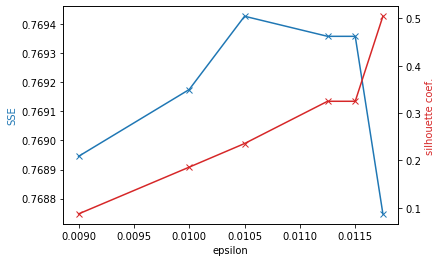

In [25]:
validate(training)

In [49]:
point_labels_valid

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [50]:
clusters_train

[[], array([   0.,    6.,   19., ..., 1932.,  224., 1492.])]

In [52]:
validation

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,YEAR
556,0.020435,0.018374,0.021066,0.021018,0.018462,0.021232,0.021114,0.020312,0.016087,0.022484,0.019088,0.021975,0.016451,0.021247,0.020721,0.021224,0.021705,0.020155,-0.018333,0.020182
2087,0.022351,0.035600,0.021670,0.018834,0.030246,0.021879,0.019301,0.016677,0.021235,0.020142,0.015884,0.016648,0.020948,0.022113,0.019364,0.021574,0.019087,0.019561,0.003860,0.020192
357,0.019158,0.020671,0.020559,0.020316,0.019387,0.021596,0.019946,0.019563,0.020055,0.019005,0.016618,0.020421,0.024842,0.021371,0.020351,0.021808,0.019203,0.019650,-0.011000,0.020182
543,0.019158,0.020671,0.019799,0.019887,0.017675,0.020059,0.019583,0.020205,0.020270,0.020343,0.019488,0.021475,0.018700,0.019473,0.019775,0.020814,0.019261,0.019858,-0.010614,0.020172
789,0.019158,0.008039,0.017870,0.021856,0.003275,0.018037,0.020308,0.025229,0.020162,0.022819,0.022959,0.020698,0.022429,0.018854,0.019652,0.016605,0.021240,0.018639,-0.035122,0.020172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.019158,0.017226,0.021728,0.019575,0.027885,0.020949,0.020469,0.022129,0.018232,0.020945,0.017353,0.021253,0.015519,0.020670,0.020515,0.021399,0.020251,0.021225,-0.006754,0.020202
639,0.019158,0.013781,0.020228,0.021642,0.011487,0.020059,0.021598,0.019777,0.017374,0.022417,0.019288,0.012819,0.021113,0.020009,0.022612,0.019937,0.019901,0.020423,-0.027017,0.020212
2108,0.022990,0.022968,0.021027,0.018581,0.029285,0.020990,0.019261,0.021701,0.020055,0.019674,0.020623,0.023251,0.020016,0.022072,0.019282,0.019060,0.019087,0.020780,-0.002123,0.020202
2291,0.019797,0.032155,0.020228,0.018932,0.024780,0.021475,0.020026,0.022129,0.027777,0.021414,0.019021,0.022474,0.027584,0.021330,0.019487,0.021867,0.020716,0.021434,-0.003474,0.020202
